# Modeling and Simulation in Python

Case study: Spider-Man

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *


I'll start by getting the units we'll need from Pint.

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
N = UNITS.newton
degree = UNITS.degree
radian = UNITS.radian

<Unit('radian')>

### Spider-Man

In this case study we'll develop a model of Spider-Man swinging from a springy cable of webbing attached to the top of the Empire State Building.  Initially, Spider-Man is at the top of a nearby building, as shown in this diagram.

![](diagrams/spiderman.png)

The origin, `O⃗`, is at the base of the Empire State Building.  The vector `H⃗` represents the position where the webbing is attached to the building, relative to `O⃗`.  The vector `P⃗` is the position of Spider-Man relative to `O⃗`.  And `L⃗` is the vector from the attachment point to Spider-Man.

By following the arrows from `O⃗`, along `H⃗`, and along `L⃗`, we can see that 

`H⃗ + L⃗ = P⃗`

So we can compute `L⃗` like this:

`L⃗ = P⃗ - H⃗`

The goals of this case study are:

1. Implement a model of this scenario to predict Spider-Man's trajectory.

2. Choose the right time for Spider-Man to let go of the webbing in order to maximize the distance he travels before landing.

3. Choose the best angle for Spider-Man to jump off the building, and let go of the webbing, to maximize range.

I'll create a `Params` object to contain the quantities we'll need:

1. According to [the Spider-Man Wiki](http://spiderman.wikia.com/wiki/Peter_Parker_%28Earth-616%29), Spider-Man weighs 76 kg.

2. Let's assume his terminal velocity is 60 m/s.

3. The length of the web is 100 m.

4. The initial angle of the web is 45 degrees to the left of straight down.

5. The spring constant of the web is 40 N / m when the cord is stretched, and 0 when it's compressed.

Here's a `Params` object.

In [3]:
params = Params(height = 381 * m,
                g = 9.8 * m/s**2,
                mass = 75 * kg,
                area = 1 * m**2,
                rho = 1.2 * kg/m**3,
                v_term = 60 * m / s,
                length = 100 * m,
                angle = (270 - 45) * degree,
                k = 40 * N / m,
                t_0 = 0 * s,
                t_end = 30 * s)

,values
height,381 meter
g,9.8 meter / second ** 2
mass,75 kilogram
area,1 meter ** 2
rho,1.2 kilogram / meter ** 3
v_term,60.0 meter / second
length,100 meter
angle,225 degree
k,40.0 newton / meter
t_0,0 second


Compute the initial position

In [4]:
def initial_condition(params):
    """Compute the initial position and velocity.
    
    params: Params object
    """
    height, length, angle = params.height, params.length, params.angle
    
    H⃗ = Vector(0, height)
    theta = angle.to(radian)
    x, y = pol2cart(theta, length)
    L⃗ = Vector(x, y)
    P⃗ = H⃗ + L⃗
    V⃗ = Vector(0, 0) * m/s
    
    return State(P⃗=P⃗, V⃗=V⃗)

In [5]:
initial_condition(params)

,values
P⃗,"[-70.71067811865477 meter, 310.28932188134524 ..."
V⃗,"[0.0 meter / second, 0.0 meter / second]"


Now here's a version of `make_system` that takes a `Params` object as a parameter.

`make_system` uses the given value of `v_term` to compute the drag coefficient `C_d`.

In [6]:
def make_system(params):
    """Makes a System object for the given conditions.
    
    params: Params object
    
    returns: System object
    """
    init = initial_condition(params)
    
    mass, g = params.mass, params.g
    rho, area, v_term = params.rho, params.area, params.v_term
    C_d = 2 * mass * g / (rho * area * v_term**2)
    
    return System(params, init=init, C_d=C_d)

Let's make a `System`

In [7]:
system = make_system(params)

,values
height,381 meter
g,9.8 meter / second ** 2
mass,75 kilogram
area,1 meter ** 2
rho,1.2 kilogram / meter ** 3
v_term,60.0 meter / second
length,100 meter
angle,225 degree
k,40.0 newton / meter
t_0,0 second


In [8]:
system.init

,values
P⃗,"[-70.71067811865477 meter, 310.28932188134524 ..."
V⃗,"[0.0 meter / second, 0.0 meter / second]"


### Drag and spring forces

Here's drag force, as we saw in Chapter 22.

In [9]:
def drag_force(V⃗, system):
    """Compute drag force.
    
    V: velocity Vector
    system: `System` object
    
    returns: force Vector
    """
    rho, C_d, area = system.rho, system.C_d, system.area
    
    mag = rho * V⃗.mag**2 * C_d * area / 2
    direction = -V⃗.hat()
    f_drag = direction * mag
    return f_drag

In [10]:
V⃗_test = Vector(10, 10) * m/s

array([10., 10.]) <Unit('meter / second')>

In [11]:
drag_force(V⃗_test, system)

array([-28.8735269, -28.8735269]) <Unit('kilogram * meter / second ** 2')>

And here's the 2-D version of spring force.  We saw the 1-D version in Chapter 21.

In [12]:
def spring_force(L⃗, system):
    """Compute drag force.
    
    L⃗: Vector representing the webbing
    system: System object
    
    returns: force Vector
    """
    extension = L⃗.mag - system.length
    if magnitude(extension) < 0:
        mag = 0
    else:
        mag = system.k * extension
        
    direction = -L⃗.hat()
    f_spring = direction * mag
    return f_spring

In [13]:
L⃗_test = Vector(0, -system.length-1*m)

array([   0, -101]) <Unit('meter')>

In [14]:
f_spring = spring_force(L⃗_test, system)

array([-0., 40.]) <Unit('newton')>

Here's the slope function, including acceleration due to gravity, drag, and the spring force of the webbing.

In [19]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    P⃗, V⃗ = state
    g, mass = system.g, system.mass
    
    H⃗ = Vector(0, system.height)
    L⃗ = P⃗ - H⃗
    
    a_grav = Vector(0, -g)
    a_spring = spring_force(L⃗, system) / mass
    a_drag = drag_force(V⃗, system) / mass
    
    A⃗ = a_grav + a_drag + a_spring
    
    return V⃗, A⃗

As always, let's test the slope function with the initial conditions.

In [20]:
slope_func(system.init, 0, system)

(array([0., 0.]) <Unit('meter / second')>,
 array([ 5.35924893e-15, -9.80000000e+00]) <Unit('meter / second ** 2')>)

And then run the simulation.

In [21]:
%time results, details = run_ode_solver(system, slope_func)
details

CPU times: user 462 ms, sys: 3.8 ms, total: 466 ms
Wall time: 457 ms


,values
success,True
message,The solver successfully reached the end of the...


### Visualizing the results

We can extract the x and y components as `Series` objects.

The simplest way to visualize the results is to plot x and y as functions of time.

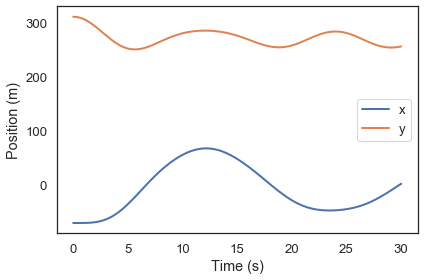

In [22]:
def plot_position(P⃗):
    x = P⃗.extract('x')
    y = P⃗.extract('y')
    plot(x, label='x')
    plot(y, label='y')

    decorate(xlabel='Time (s)',
             ylabel='Position (m)')
    
plot_position(results.P⃗)

We can plot the velocities the same way.

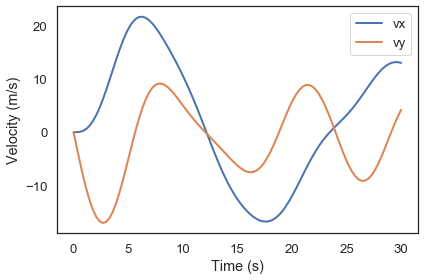

In [23]:
def plot_velocity(V⃗):
    vx = V⃗.extract('x')
    vy = V⃗.extract('y')
    plot(vx, label='vx')
    plot(vy, label='vy')

    decorate(xlabel='Time (s)',
             ylabel='Velocity (m/s)')
    
plot_velocity(results.V⃗)

Another way to visualize the results is to plot y versus x.  The result is the trajectory through the plane of motion.

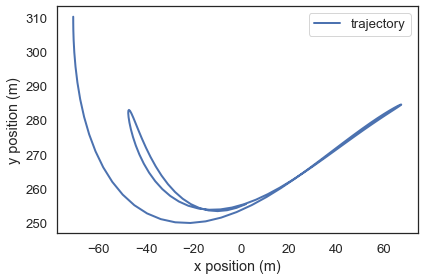

In [24]:
def plot_trajectory(P⃗, **options):
    x = P⃗.extract('x')
    y = P⃗.extract('y')
    plot(x, y, **options)
    
    decorate(xlabel='x position (m)',
             ylabel='y position (m)')
    
plot_trajectory(results.P⃗, label='trajectory')

### Letting go

Now let's find the optimal time for Spider-Man to let go.  We have to run the simulation in two phases because the spring force changes abruptly when Spider-Man lets go, so we can't integrate through it.

Here are the parameters for Phase 1, running for 9 seconds.

CPU times: user 445 ms, sys: 481 µs, total: 445 ms
Wall time: 431 ms


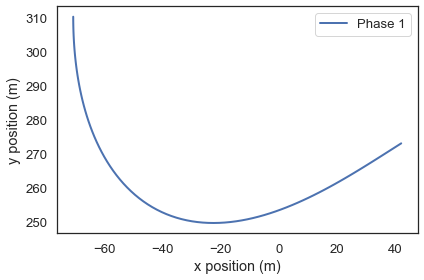

In [25]:
params1 = Params(params, t_end=9*s)
system1 = make_system(params1)
%time results1, details1 = run_ode_solver(system1, slope_func)
plot_trajectory(results1.P⃗, label='Phase 1')

The final conditions from Phase 1 are the initial conditions for Phase 2.

In [26]:
t_final = get_last_label(results1) * s

8.999999999999991 <Unit('second')>

Here's the position Vector.

In [27]:
init = results1.last_row()
init.P⃗

array([ 42.09220705, 273.05201433]) <Unit('meter')>

And the velocity Vector.

In [28]:
init.V⃗

array([14.62550768,  7.93776508]) <Unit('meter / second')>

Here is the `System` for Phase 2.  We can turn off the spring force by setting `k=0`, so we don't have to write a new slope function.

In [29]:
system2 = System(system1, t_0=t_final, t_end=t_final+10*s, init=init, k=0*N/m)

,values
height,381 meter
g,9.8 meter / second ** 2
mass,75 kilogram
area,1 meter ** 2
rho,1.2 kilogram / meter ** 3
v_term,60.0 meter / second
length,100 meter
angle,225 degree
k,0.0 newton / meter
t_0,8.999999999999991 second


Here's an event function that stops the simulation when Spider-Man reaches the ground.

In [30]:
def event_func(state, t, system):
    """Stops when y=0.
    
    state: State object
    t: time
    system: System object
    
    returns: height
    """
    P⃗, V⃗ = state
    return P⃗.y

Run Phase 2.

In [31]:
%time results2, details2 = run_ode_solver(system2, slope_func, events=event_func)

CPU times: user 251 ms, sys: 7.03 ms, total: 258 ms
Wall time: 236 ms


Plot the results.

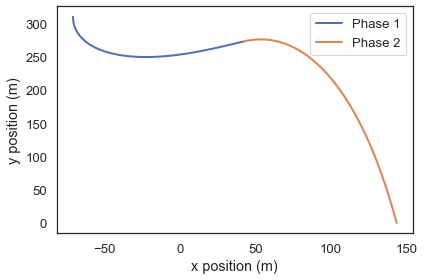

In [32]:
plot_trajectory(results1.P⃗, label='Phase 1')
plot_trajectory(results2.P⃗, label='Phase 2')

Now we can gather all that into a function that takes `t_release` and `V_0`, runs both phases, and returns the results.

In [33]:
def run_two_phase(t_release, V⃗_0, params):
    """Run both phases.
    
    t_release: time when Spider-Man lets go of the webbing
    V_0: initial velocity
    """
    params1 = Params(params, t_end=t_release, V⃗_0=V⃗_0)
    system1 = make_system(params1)
    results1, details1 = run_ode_solver(system1, slope_func)

    t_0 = get_last_label(results1) * s
    t_end = t_0 + 10 * s
    init = results1.last_row()

    system2 = System(system1, t_0=t_0, t_end=t_end, init=init, k=0*N/m)
    results2, details2 = run_ode_solver(system2, slope_func, events=event_func)

    results = results1.combine_first(results2)
    return TimeFrame(results)

And here's a test run.

143.42923899746137 <Unit('meter')>

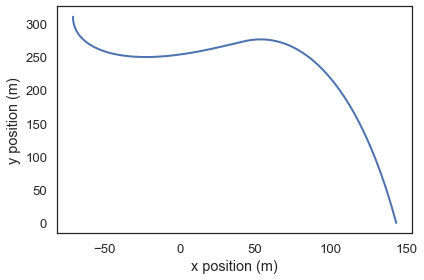

In [34]:
t_release = 9 * s
V⃗_0 = Vector(0, 0) * m/s

results = run_two_phase(t_release, V⃗_0, params)
plot_trajectory(results.P⃗)
x_final = results.P⃗.last_value().x

### Maximizing range

To find the best value of `t_release`, we need a function that takes possible values, runs the simulation, and returns the range.

In [35]:
def range_func(t_release, params):
    """Compute the final value of x.
    
    t_release: time to release web
    params: Params object
    """
    V_0 = Vector(0, 0) * m/s
    results = run_two_phase(t_release, V_0, params)
    x_final = results.P⃗.last_value().x
    print(t_release, x_final)
    return x_final

We can test it.

In [36]:
range_func(9*s, params)

9 second 143.42923899746137 meter


143.42923899746137 <Unit('meter')>

And run it for a few values.

In [37]:
for t_release in linrange(3, 15, 3) * s:
    range_func(t_release, params)

3 second -22.692190755854355 meter
6 second 116.11308034729514 meter
9 second 143.42923899746137 meter
12 second 74.31597234272962 meter


Now we can use `maximize_scalar` to find the optimum.

In [38]:
bounds = [6, 12] * s
res = maximize_golden(range_func, bounds, params)

6 second 116.11308034729514 meter
12 second 74.31597234272962 meter
8.29179606750063 second 148.81267917483396 meter
9.70820393249937 second 133.71516703261784 meter
7.416407864998738 second 147.36550733035398 meter
8.832815729997476 second 145.11804216776218 meter
7.957427527495583 second 149.51213728788494 meter
7.750776405003785 second 149.20934157535223 meter
8.085144945008832 second 149.40387887039554 meter
7.878493822517034 second 149.465949762932 meter
8.006211240030282 second 149.495458639697 meter
7.927277535051734 second 149.50430409600335 meter
7.976061247586434 second 149.50964614652324 meter
7.945911255142585 second 149.51055843937752 meter
7.964544975233436 second 149.51196129164632 meter
7.953028702880438 second 149.51173940695702 meter
7.960146150618292 second 149.51225671813503 meter
7.9618263521107275 second 149.5122553663233 meter


,values
success,True
x,7.960146150618292 second
fun,149.51225671813503 meter


Finally, we can run the simulation with the optimal value.

149.51225671813503 <Unit('meter')>

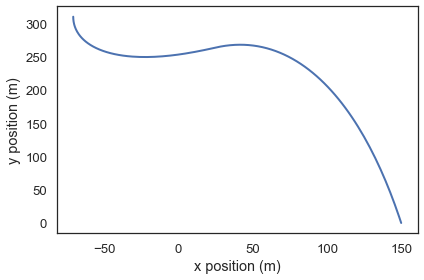

In [39]:
best_time = res.x
V⃗_0 = Vector(0, 0) * m/s
results = run_two_phase(best_time, V⃗_0, params)
plot_trajectory(results.P⃗)
x_final = results.P⃗.last_value().x